In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
path = '/content/drive/MyDrive/Research/AAAI/dataset2/first_layer_with_entropy/'

In [30]:
import numpy as np
import pandas as pd

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib import pyplot as plt
%matplotlib inline

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Generate dataset

In [32]:
mu1 = np.array([3,3,3,3,0])
sigma1 = np.array([[1,1,1,1,1],[1,16,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]])

mu2 = np.array([4,4,4,4,0])
sigma2 = np.array([[16,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]])

mu3 = np.array([10,5,5,10,0])
sigma3 = np.array([[1,1,1,1,1],[1,16,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]])

mu4 = np.array([-10,-10,-10,-10,0])
sigma4 = np.array([[1,1,1,1,1],[1,16,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]])

mu5 = np.array([-21,4,4,-21,0])
sigma5 = np.array([[16,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]])

mu6 = np.array([-10,18,18,-10,0])
sigma6 = np.array([[1,1,1,1,1],[1,16,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]])

mu7 = np.array([4,20,4,20,0])
sigma7 = np.array([[16,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]])

mu8 = np.array([4,-20,-20,4,0])
sigma8 = np.array([[16,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]])

mu9 = np.array([20,20,20,20,0])
sigma9 = np.array([[1,1,1,1,1],[1,16,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]])

mu10 = np.array([20,-10,-10,20,0])
sigma10 = np.array([[1,1,1,1,1],[1,16,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]])

In [33]:
np.random.seed(12)
sample1 = np.random.multivariate_normal(mean=mu1,cov= sigma1,size=500)
sample2 = np.random.multivariate_normal(mean=mu2,cov= sigma2,size=500)
sample3 = np.random.multivariate_normal(mean=mu3,cov= sigma3,size=500)
sample4 = np.random.multivariate_normal(mean=mu4,cov= sigma4,size=500)
sample5 = np.random.multivariate_normal(mean=mu5,cov= sigma5,size=500)
sample6 = np.random.multivariate_normal(mean=mu6,cov= sigma6,size=500)
sample7 = np.random.multivariate_normal(mean=mu7,cov= sigma7,size=500)
sample8 = np.random.multivariate_normal(mean=mu8,cov= sigma8,size=500)
sample9 = np.random.multivariate_normal(mean=mu9,cov= sigma9,size=500)
sample10 = np.random.multivariate_normal(mean=mu10,cov= sigma10,size=500)

In [34]:
X = np.concatenate((sample1,sample2,sample3,sample4,sample5,sample6,sample7,sample8,sample9,sample10),axis=0)
Y = np.concatenate((np.zeros((500,1)),np.ones((500,1)),2*np.ones((500,1)),3*np.ones((500,1)),4*np.ones((500,1)),
                    5*np.ones((500,1)),6*np.ones((500,1)),7*np.ones((500,1)),8*np.ones((500,1)),9*np.ones((500,1))),axis=0).astype(int)

In [35]:
print(X[0], Y[0])

[ 2.20218134  1.32290141  2.20218134  2.20218134 -0.79781866] [0]


In [36]:
print(X[500], Y[500])

[12.65418869  5.7937588   5.7937588   5.7937588   1.7937588 ] [1]


In [37]:
class SyntheticDataset(Dataset):
  """MosaicDataset dataset."""
  def __init__(self, x, y):
    """
      Args:
       x: list of instance
       y: list of instance label
    """
    self.x = x
    self.y = y
    #self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    return self.x[idx] , self.y[idx] #, self.fore_idx[idx]

trainset = SyntheticDataset(X,Y)

classes = ('zero','one','two','three','four','five','six','seven','eight','nine')

foreground_classes = {'zero','one','two'}
fg_used = '012'
fg1, fg2, fg3 = 0,1,2

all_classes = {'zero','one','two','three','four','five','six','seven','eight','nine'}
background_classes = all_classes - foreground_classes
print("background classes ",background_classes)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=False)

dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=100

for i in range(50):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data.append(img)
      background_label.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data.append(img)
      foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)

background classes  {'five', 'nine', 'eight', 'seven', 'four', 'six', 'three'}


In [38]:
print(foreground_data[0], foreground_label[0] )

tensor([ 2.2022,  1.3229,  2.2022,  2.2022, -0.7978]) tensor(0)


In [39]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
    if i != fg:
      image_list.append(background_data[bg_idx[j]])
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx])
      label = foreground_label[fg_idx] - fg1  # minus fg1 because our fore ground classes are fg1,fg2,fg3 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [40]:
desired_num = 6000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
list_set_labels = [] 
for i in range(desired_num):
  set_idx = set()
  np.random.seed(i)
  bg_idx = np.random.randint(0,3500,8)
  set_idx = set(background_label[bg_idx].tolist())
  fg_idx = np.random.randint(0,1500)
  set_idx.add(foreground_label[fg_idx].item())
  fg = np.random.randint(0,9)
  fore_idx.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  mosaic_list_of_images.append(image_list)
  mosaic_label.append(label)
  list_set_labels.append(set_idx)

In [41]:
len(mosaic_list_of_images), mosaic_list_of_images[0]

(6000, tensor([[ 20.0825,  25.5012,  20.0825,  20.0825,   0.0825],
         [ 20.6911,  22.6202,  20.6911,  20.6911,   0.6911],
         [  1.2544,  22.0426,   6.0426,  22.0426,   2.0426],
         [  9.2862,   3.1005,   4.2862,   9.2862,  -0.7138],
         [ 20.7622, -12.2787,  -9.2378,  20.7622,   0.7622],
         [-27.2336,   3.4770,   3.4770, -21.5230,  -0.5230],
         [-32.2853,   1.7774,   1.7774, -23.2226,  -2.2226],
         [  4.1916,  17.4376,   1.4376,  17.4376,  -2.5624],
         [ 20.9615,  -4.3890,  -9.0385,  20.9615,   0.9615]]))

# load mosaic data

In [42]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list, mosaic_label,fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list
    self.label = mosaic_label
    self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx] , self.fore_idx[idx]

In [43]:
batch = 250
msd1 = MosaicDataset(mosaic_list_of_images[0:3000], mosaic_label[0:3000] , fore_idx[0:3000])
train_loader = DataLoader( msd1 ,batch_size= batch ,shuffle=True)

In [44]:
batch = 250
msd2 = MosaicDataset(mosaic_list_of_images[3000:6000], mosaic_label[3000:6000] , fore_idx[3000:6000])
test_loader = DataLoader( msd2 ,batch_size= batch ,shuffle=True)

# models

In [45]:
class Focus_deep(nn.Module):
    '''
       deep focus network averaged at zeroth layer with input-6-12-output architecture
       input : elemental data
    '''
    def __init__(self,inputs,output,K,d):
        super(Focus_deep,self).__init__()
        self.inputs = inputs
        self.output = output
        self.K = K
        self.d  = d
        self.linear1 = nn.Linear(self.inputs,6, bias=False)  #,self.output)
        self.linear2 = nn.Linear(6,12, bias=False)
        self.linear3 = nn.Linear(12,self.output, bias=False) 

        torch.nn.init.xavier_normal_(self.linear1.weight)
        torch.nn.init.xavier_normal_(self.linear2.weight)
        torch.nn.init.xavier_normal_(self.linear3.weight)
        
    def forward(self,z):
        batch = z.shape[0]
        x = torch.zeros([batch,self.K],dtype=torch.float64)
        y = torch.zeros([batch,6], dtype=torch.float64)   # number of features of output
        features = torch.zeros([batch,self.K,6],dtype=torch.float64)
        x,y = x.to(device),y.to(device)
        features = features.to(device)
        for i in range(self.K):
            alp,ftrs = self.helper(z[:,i] )  # self.d*i:self.d*i+self.d
            x[:,i] = alp[:,0]
            features[:,i]  = ftrs 
        log_x = F.log_softmax(x,dim=1)  # log_alphas
        x = F.softmax(x,dim=1)   # alphas
        
        for i in range(self.K):
            x1 = x[:,i]          
            y = y+torch.mul(x1[:,None],features[:,i])  # self.d*i:self.d*i+self.d
        return y , x,log_x 
    def helper(self,x):
      x = self.linear1(x)
      x1 = F.tanh(x)
      x = F.relu(x) 
      x = self.linear2(x)
      #x1 = F.tanh(x)
      x = F.relu(x)
      x = self.linear3(x)
      return x,x1

In [46]:
class Classification_deep(nn.Module):
    '''
       input : elemental data
       deep classification module data averaged at zeroth layer with architecture input-6-12-output
    '''
    def __init__(self,inputs,output):
        super(Classification_deep,self).__init__()
        self.inputs = inputs
        self.output = output
        self.linear1 = nn.Linear(self.inputs,6)
        self.linear2 = nn.Linear(6,12)
        self.linear3 = nn.Linear(12,self.output)

        torch.nn.init.xavier_normal_(self.linear1.weight)
        torch.nn.init.zeros_(self.linear1.bias)
        torch.nn.init.xavier_normal_(self.linear2.weight)
        torch.nn.init.zeros_(self.linear2.bias)
        torch.nn.init.xavier_normal_(self.linear3.weight)
        torch.nn.init.zeros_(self.linear3.bias)

    def forward(self,x):
      x = F.relu(self.linear1(x))
      x = F.relu(self.linear2(x))
      x = self.linear3(x)
      return x

In [47]:
torch.manual_seed(12)
focus_net = Focus_deep(2,1,9,2).double()
focus_net = focus_net.to("cuda")

In [48]:
focus_net.linear2.weight.shape,focus_net.linear3.weight.shape

(torch.Size([12, 6]), torch.Size([1, 12]))

In [49]:
focus_net.linear2.weight.data[6:,:] = focus_net.linear2.weight.data[:6,:] #torch.nn.Parameter(torch.tensor([last_layer]) )
(focus_net.linear2.weight[:6,:]== focus_net.linear2.weight[6:,:] )

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True]], device='cuda:0')

In [50]:
focus_net.linear3.weight.data[:,6:] = -focus_net.linear3.weight.data[:,:6] #torch.nn.Parameter(torch.tensor([last_layer]) )
focus_net.linear3.weight

Parameter containing:
tensor([[-0.1695, -0.0642,  0.4469, -0.3091, -0.1205, -0.3258,  0.1695,  0.0642,
         -0.4469,  0.3091,  0.1205,  0.3258]], device='cuda:0',
       dtype=torch.float64, requires_grad=True)

In [51]:
ex, _ = focus_net.helper( torch.randn((1,2,9)).double().to("cuda") )
print(ex)

tensor([[[ 6.9389e-18],
         [-6.9389e-18]]], device='cuda:0', dtype=torch.float64,
       grad_fn=<UnsafeViewBackward>)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [52]:
criterion = nn.CrossEntropyLoss()
def my_cross_entropy(x, y,alpha,log_alpha,k):
    # log_prob = -1.0 * F.log_softmax(x, 1)
    # loss = log_prob.gather(1, y.unsqueeze(1))
    # loss = loss.mean()
    loss = criterion(x,y)
    
    #alpha = torch.clamp(alpha,min=1e-10)     
    
    b = -1.0* alpha * log_alpha
    b =  torch.mean(torch.sum(b,dim=1))
    closs = loss
    entropy = b 
    loss = (1-k)*loss + ((k)*b)
    return loss,closs,entropy

In [53]:
def calculate_attn_loss(dataloader,what,where,criter,k):
  what.eval()
  where.eval()
  r_loss = 0
  cc_loss = 0
  cc_entropy = 0
  alphas = []
  lbls = []
  pred = []
  fidices = []
  with torch.no_grad():
    for i, data in enumerate(dataloader, 0):
      inputs, labels,fidx = data
      lbls.append(labels)
      fidices.append(fidx)
      inputs = inputs.double()
      inputs, labels = inputs.to("cuda"),labels.to("cuda")
      avg,alpha,log_alpha = where(inputs)
      outputs = what(avg)
      _, predicted = torch.max(outputs.data, 1)
      pred.append(predicted.cpu().numpy())
      alphas.append(alpha.cpu().numpy())

      #ent = np.sum(entropy(alpha.cpu().detach().numpy(), base=2, axis=1))/batch
      # mx,_ = torch.max(alpha,1)
      # entropy = np.mean(-np.log2(mx.cpu().detach().numpy()))
      # print("entropy of batch", entropy)

      #loss = (1-k)*criter(outputs, labels) + k*ent
      loss,closs,entropy = my_cross_entropy(outputs,labels,alpha,log_alpha,k)
      r_loss += loss.item()
      cc_loss += closs.item()
      cc_entropy += entropy.item()

  alphas = np.concatenate(alphas,axis=0)
  pred = np.concatenate(pred,axis=0)
  lbls = np.concatenate(lbls,axis=0)
  fidices = np.concatenate(fidices,axis=0)
  #print(alphas.shape,pred.shape,lbls.shape,fidices.shape) 
  analysis = analyse_data(alphas,lbls,pred,fidices)
  return r_loss/i,cc_loss/i,cc_entropy/i,analysis

In [54]:
def analyse_data(alphas,lbls,predicted,f_idx):
    '''
       analysis data is created here
    '''
    batch = len(predicted)
    amth,alth,ftpt,ffpt,ftpf,ffpf = 0,0,0,0,0,0
    for j in range (batch):
      focus = np.argmax(alphas[j])
      if(alphas[j][focus] >= 0.5):
        amth +=1
      else:
        alth +=1
      if(focus == f_idx[j] and predicted[j] == lbls[j]):
        ftpt += 1
      elif(focus != f_idx[j] and predicted[j] == lbls[j]):
        ffpt +=1
      elif(focus == f_idx[j] and predicted[j] != lbls[j]):
        ftpf +=1
      elif(focus != f_idx[j] and predicted[j] != lbls[j]):
        ffpf +=1
    #print(sum(predicted==lbls),ftpt+ffpt)
    return [ftpt,ffpt,ftpf,ffpf,amth,alth]

# training

In [55]:
number_runs = 10
full_analysis =[]
FTPT_analysis = pd.DataFrame(columns = ["FTPT","FFPT", "FTPF","FFPF"])
k = 0
for n in range(number_runs):
  print("--"*40)
  
  # instantiate focus and classification Model
  torch.manual_seed(n)
  where = Focus_deep(5,1,9,5).double()
  where.linear2.weight.data[6:,:] = where.linear2.weight.data[:6,:]
  where.linear3.weight.data[:,6:] = -where.linear3.weight.data[:,:6]
  where = where.double().to("cuda")

  ex, _ = focus_net.helper( torch.randn((1,2,9)).double().to("cuda") )
  print(ex)

  what = Classification_deep(6,3).double()
  where = where.to("cuda")
  what = what.to("cuda")

  # instantiate optimizer
  optimizer_where = optim.Adam(where.parameters(),lr =0.001)
  optimizer_what = optim.Adam(what.parameters(), lr=0.001)
  #criterion = nn.CrossEntropyLoss()
  acti = []
  analysis_data = []
  loss_curi = []
  epochs = 2000


  # calculate zeroth epoch loss and FTPT values
  running_loss ,_,_,anlys_data= calculate_attn_loss(train_loader,what,where,criterion,k)
  loss_curi.append(running_loss)
  analysis_data.append(anlys_data)

  print('epoch: [%d ] loss: %.3f' %(0,running_loss)) 

  # training starts 
  for epoch in range(epochs): # loop over the dataset multiple times
    ep_lossi = []
    running_loss = 0.0
    what.train()
    where.train()
    for i, data in enumerate(train_loader, 0):
      # get the inputs
      inputs, labels,_ = data
      inputs = inputs.double()
      inputs, labels = inputs.to("cuda"),labels.to("cuda")

      # zero the parameter gradients
      optimizer_where.zero_grad()
      optimizer_what.zero_grad()
      
      # forward + backward + optimize
      avg, alpha,log_alpha = where(inputs)
      outputs = what(avg)

      my_loss,_,_ = my_cross_entropy(outputs,labels,alpha,log_alpha,k)

      # print statistics
      running_loss += my_loss.item()
      my_loss.backward()
      optimizer_where.step()
      optimizer_what.step()
    #break
    running_loss,ccloss,ccentropy,anls_data = calculate_attn_loss(train_loader,what,where,criterion,k)
    analysis_data.append(anls_data)

    if(epoch % 200==0):
      print('epoch: [%d] loss: %.3f celoss: %.3f entropy: %.3f' %(epoch + 1,running_loss,ccloss,ccentropy)) 
    loss_curi.append(running_loss)   #loss per epoch
    if running_loss<=0.01:
      print('breaking in epoch: ', epoch)
      break
  print('Finished Training run ' +str(n))
  #break
  analysis_data = np.array(analysis_data)
  FTPT_analysis.loc[n] = analysis_data[-1,:4]/30
  full_analysis.append((epoch, analysis_data))
  correct = 0
  total = 0
  with torch.no_grad():
    for data in test_loader:
      images, labels,_ = data
      images = images.double()
      images, labels = images.to("cuda"), labels.to("cuda")
      avg, alpha,log_alpha = where(images)
      outputs  = what(avg)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the 3000 test images: %f %%' % (  100 * correct / total))
    

--------------------------------------------------------------------------------
tensor([[[ 0.0000e+00],
         [-9.5410e-18]]], device='cuda:0', dtype=torch.float64,
       grad_fn=<UnsafeViewBackward>)
epoch: [0 ] loss: 1.203


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch: [1] loss: 1.197 celoss: 1.197 entropy: 2.330
epoch: [201] loss: 0.012 celoss: 0.012 entropy: 0.502
breaking in epoch:  210
Finished Training run 0
Accuracy of the network on the 3000 test images: 99.566667 %
--------------------------------------------------------------------------------
tensor([[[0.],
         [0.]]], device='cuda:0', dtype=torch.float64,
       grad_fn=<UnsafeViewBackward>)
epoch: [0 ] loss: 1.202
epoch: [1] loss: 1.198 celoss: 1.198 entropy: 2.395
epoch: [201] loss: 0.145 celoss: 0.145 entropy: 0.838
epoch: [401] loss: 0.081 celoss: 0.081 entropy: 0.699
epoch: [601] loss: 0.066 celoss: 0.066 entropy: 0.657
epoch: [801] loss: 0.054 celoss: 0.054 entropy: 0.627
epoch: [1001] loss: 0.046 celoss: 0.046 entropy: 0.640
epoch: [1201] loss: 0.038 celoss: 0.038 entropy: 0.635
epoch: [1401] loss: 0.034 celoss: 0.034 entropy: 0.619
epoch: [1601] loss: 0.032 celoss: 0.032 entropy: 0.597
epoch: [1801] loss: 0.031 celoss: 0.031 entropy: 0.584
Finished Training run 1
Accura

In [62]:
print(np.mean(np.array(FTPT_analysis),axis=0)) 

[81.11       18.63        0.14333333  0.11666667]


In [57]:
FTPT_analysis

,FTPT,FFPT,FTPF,FFPF
0,67.666667,32.100000,0.233333,0.000000
1,72.000000,26.966667,0.233333,0.800000
2,67.266667,32.400000,0.033333,0.300000
3,100.000000,0.000000,0.000000,0.000000
4,99.300000,0.366667,0.333333,0.000000
5,85.966667,13.900000,0.133333,0.000000
6,83.733333,16.033333,0.200000,0.033333
7,100.000000,0.000000,0.000000,0.000000
8,67.566667,32.233333,0.166667,0.033333
9,67.600000,32.300000,0.100000,0.000000


In [58]:
FTPT_analysis[FTPT_analysis['FTPT']+FTPT_analysis['FFPT'] > 90 ]

,FTPT,FFPT,FTPF,FFPF
0,67.666667,32.100000,0.233333,0.000000
1,72.000000,26.966667,0.233333,0.800000
2,67.266667,32.400000,0.033333,0.300000
3,100.000000,0.000000,0.000000,0.000000
4,99.300000,0.366667,0.333333,0.000000
5,85.966667,13.900000,0.133333,0.000000
6,83.733333,16.033333,0.200000,0.033333
7,100.000000,0.000000,0.000000,0.000000
8,67.566667,32.233333,0.166667,0.033333
9,67.600000,32.300000,0.100000,0.000000


In [59]:
print(np.mean(np.array(FTPT_analysis[FTPT_analysis['FTPT']+FTPT_analysis['FFPT'] > 90 ]),axis=0))

[81.11       18.63        0.14333333  0.11666667]


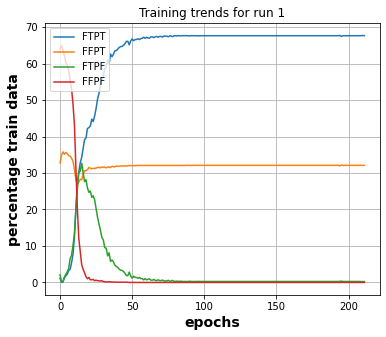

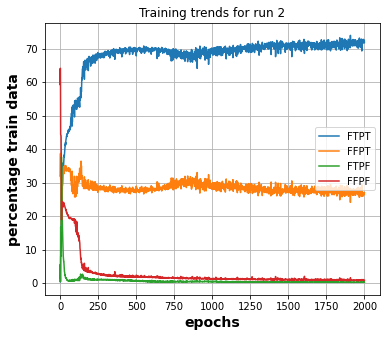

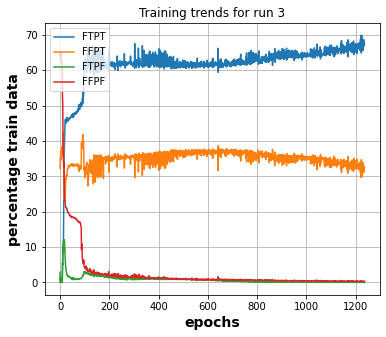

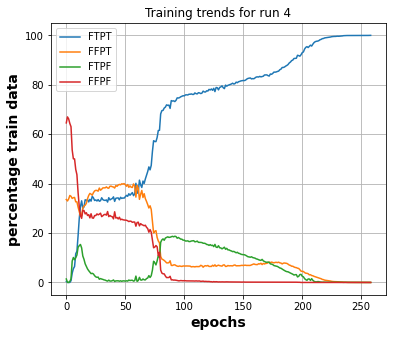

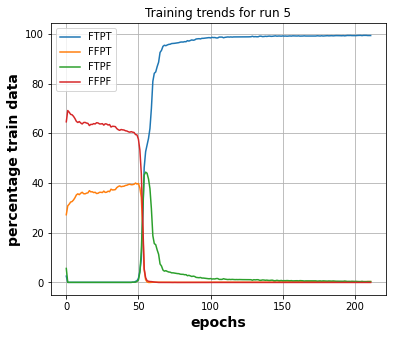

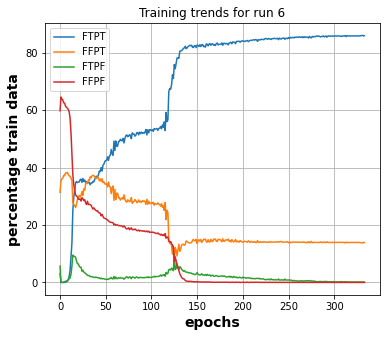

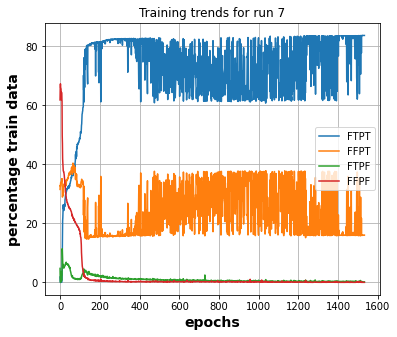

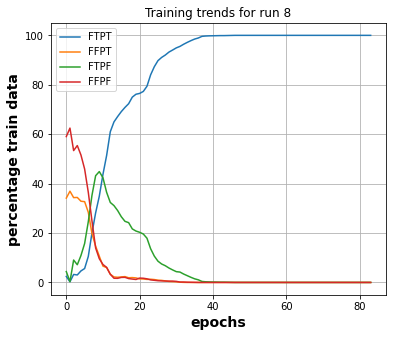

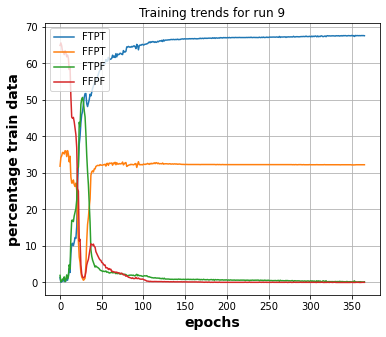

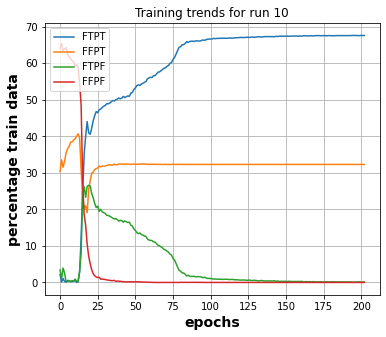

In [60]:
cnt=1
for epoch, analysis_data in full_analysis:
  analysis_data = np.array(analysis_data)
  # print("="*20+"run ",cnt,"="*20)
  
  plt.figure(figsize=(6,5))
  plt.plot(np.arange(0,epoch+2,1),analysis_data[:,0]/30,label="FTPT")
  plt.plot(np.arange(0,epoch+2,1),analysis_data[:,1]/30,label="FFPT")
  plt.plot(np.arange(0,epoch+2,1),analysis_data[:,2]/30,label="FTPF")
  plt.plot(np.arange(0,epoch+2,1),analysis_data[:,3]/30,label="FFPF")

  plt.title("Training trends for run "+str(cnt))
  plt.grid()
  # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.legend()
  plt.xlabel("epochs", fontsize=14, fontweight = 'bold')
  plt.ylabel("percentage train data", fontsize=14, fontweight = 'bold')
  plt.savefig(path + "run"+str(cnt)+".png",bbox_inches="tight")
  plt.savefig(path + "run"+str(cnt)+".pdf",bbox_inches="tight")
  cnt+=1

In [61]:
FTPT_analysis.to_csv(path+"synthetic_zeroth.csv",index=False)